# Investigating Trigger Efficiency with sstcam-simulation

This notebook is the first that explores how to extract trigger efficiency with the sstcam-simulation package, by simulating a periodic laser illumination. This is explored in two approaches:
1. Simulating a coninuous data taking run. This is closest to the realistic situation in the lab.
2. Measuring the percent of triggers in segments of the waveform length. This is the approach typically used in simtelarray.

The two approaches will be compared and advice is given on when to use each.

In [31]:
from sstcam_simulation import Camera, SSTCameraMapping, PhotoelectronSource, EventAcquisition
from sstcam_simulation.camera.spe import SiPMGentileSPE, PerfectPhotosensor
from sstcam_simulation.camera.pulse import GaussianPulse
from sstcam_simulation.event.trigger import sum_superpixels
import numpy as np
from tqdm import trange, tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
common_camera_config = dict(
    mapping=SSTCameraMapping(n_pixels=4),  # One superpixel
    coincidence_window=0,  # Could overlap and reduce triggers
    reference_pulse=GaussianPulse(),  # Simple gaussian pulse
    photoelectron_spectrum=SiPMGentileSPE()  # SiPM SPE
)

# Safe Threshold

Before proceeding with the trigger efficiency investigation, it is necessary to determine the safe threshold to set the camera to for the NSB rate. This involves selecting a threshold that balances between enabling the dimmest illuminations to still be caught, but minimising the number of triggers that arise from NSB photons.

A convention used in simtelarray is to select the threshold at the intersection of the two bias curves (NSB and signal, i.e. cosmic ray showers), with the NSB curve simulated with twice the operational rate. For example, the safe threshold at 20 MHz NSB is calculated by simulating the bias curve at 40 MHz NSB, and extracting the threshold corresponding to the intersection.

As we are dealing with periodic laser illuminations, the signal curve is a constant line at the set flash frequency. This makes is more straight forward to extract the safe threshold.

The bias curve provides a conversion between rate and threshold. There are multiple ways in which one could extract the threshold for a given rate. For this investigation I use a simple fit to the NSB bias curve with a straight line in log space. 

In [3]:
camera = Camera(
    **common_camera_config,
    continuous_readout_duration=5e4,  # 50 μs
)
illumination_rate = 300  # Hz
nsb_rate = 30  # MHz

In [10]:
def perform_nsb_bias_scan(camera, nsb, thresholds):
    source = PhotoelectronSource(camera=camera)
    acquisition = EventAcquisition(camera=camera)
    n_repeats = 100  # Repeats for statistics
    n_triggers = np.zeros((n_repeats, thresholds.size))
    for iev in trange(n_repeats, desc="Repeating bias curve measurement"):
        photoelectrons = source.get_nsb(nsb)
        readout = acquisition.get_continuous_readout(photoelectrons)
        for i, thresh in enumerate(thresholds):
            camera.update_trigger_threshold(thresh)
            digital_trigger = acquisition.trigger.get_superpixel_digital_trigger_line(readout)
            n_triggers[iev, i] = acquisition.trigger.get_n_superpixel_triggers(digital_trigger)
    rate = n_triggers / (camera.continuous_readout_duration * 1e-9)
    return rate.mean(0), rate.std(0)

In [11]:
def get_threshold_for_rate(thresholds, scan, requested_rate):
    gt0 = scan > 0
    gradient, y_intercept = np.polyfit(thresholds[gt0], np.log10(scan[gt0]), 1)
    required_threshold = (np.log10(requested_rate) - y_intercept) / gradient    
    return required_threshold, gradient, y_intercept

In [12]:
thresholds = np.linspace(3, 15, 10)  # Units: photoelectron

In [13]:
# Perform bias scans (first one is for plotting purposes only)
scan, scan_err = perform_nsb_bias_scan(camera, nsb_rate, thresholds)
scan_x2, scan_err_x2 = perform_nsb_bias_scan(camera, nsb_rate*2, thresholds)

Repeating bias curve measurement: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


In [79]:
safe_threshold, gradient, y_intercept = get_threshold_for_rate(thresholds, scan_x2, illumination_rate)

Text(0, 0.5, 'Trigger Rate (Hz)')

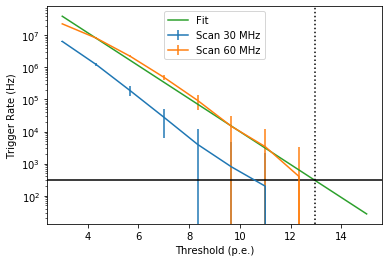

In [80]:
# Demonstrate the fit
plt.errorbar(thresholds, scan, yerr=scan_err, label=f"Scan {nsb_rate} MHz")
plt.errorbar(thresholds, scan_x2, yerr=scan_err_x2, label=f"Scan {nsb_rate*2} MHz")
plt.plot(thresholds, 10**np.polyval([gradient, y_intercept], thresholds), label="Fit")
plt.axhline(illumination_rate, color='black', ls='-')
plt.axvline(safe_threshold, color='black', ls=':')

plt.yscale('log')
plt.legend()
plt.xlabel("Threshold (p.e.)")
plt.ylabel("Trigger Rate (Hz)")

In [71]:
safe_threshold

10.484975144373397

# Approach 1: Continuous Data Taking

When measuring the trigger efficiency in the lab, the camera is turned on for a period of time with the laser flashing periodically, and the number of triggers are counted. The typical rate of laser flashes are a couple of hundred Hz, and the runs last on the "seconds" timescales.

Due to the fine sampling that is simulated for the continuous readout, and it being on the nanosecond scale, simulating a single readout of N seconds is not feasible, as it will max out the RAM. Instead the run is broken up into smaller segments. The illumination timestamps are calculated prior to simplify the injection into each corresponding segment.

In [15]:
# Duration of camera data taking
duration = 1e-2  # seconds

In [16]:
# Define the illumination source (laser)
illumination_level = 100  # p.e.
illumination_interval = 1 / illumination_rate  # seconds
illumination_timestamps = np.arange(
    illumination_interval/2, duration, illumination_interval
)  # Start at half interval to ensure it is fully within readout

In [17]:
print(f"Number of laser flashes (at {illumination_rate} Hz) in {duration} seconds = {illumination_timestamps.size}")

Number of laser flashes (at 300 Hz) in 0.01 seconds = 3


In [20]:
def count_triggers(duration, nsb, illumination_timestamps, illumination_level, safe_threshold):
    timestamps = illumination_timestamps.copy() * 1e9
    readout_duration = 5e4 # process 10 μs of readout at a time
    n_segments = int(duration * 1e9 / readout_duration)
    camera = Camera(
        **common_camera_config,
        continuous_readout_duration=readout_duration, # process 10 μs of readout at a time
        trigger_threshold=safe_threshold,
    )
    source = PhotoelectronSource(camera=camera)
    acquisition = EventAcquisition(camera=camera)
    
    n_triggers = 0
    for _ in trange(n_segments, desc=f"Camera running for {duration} seconds"):
        flashes_in_readout = timestamps[timestamps < readout_duration]
        photoelectrons = source.get_nsb(nsb)
        for t in flashes_in_readout:
            photoelectrons += source.get_uniform_illumination(t, illumination_level)        
        readout = acquisition.get_continuous_readout(photoelectrons)
        digital_trigger = acquisition.trigger.get_superpixel_digital_trigger_line(readout)
        n_triggers += acquisition.trigger.get_n_superpixel_triggers(digital_trigger)
        
        timestamps -= readout_duration
        timestamps = timestamps[timestamps >= 0]
    return n_triggers

In [21]:
n_triggers = count_triggers(duration, nsb_rate, illumination_timestamps, illumination_level, safe_threshold)[0]
print(f"Number of triggers = {n_triggers}")

Camera running for 0.01 seconds: 100%|██████████| 20000/20000 [00:40<00:00, 496.81it/s]

Number of triggers = 3


This was only 0.01 seconds simulated, taking 30 seconds real time for just one superpixel. Unfortunately, this approach will take a very long time to gather enough statistics to form the full trigger efficiency curve. The problem with this apporach is that the majority of simulated readout is empty of signal. This is the advantage of the second approach.

In special circumstances approach 1 may be required, for example, to fully check the final trigger efficiency against how the camera operates in real life. However, for optimisation investigations, I would recommend to use approach 2.

# Approach 2: Trigger Ratio

By simulating readouts of typical waveform lengths, each containing a signal pulse, we can explore the trigger efficiency with less processing time. This is the approach typically used in simtelarray, as the concept of time and continuous readout is not available in the output. See the document by Tom Armstrong in this directory.

In [66]:
n_simulated = 10000

In [67]:
def count_triggers_simulation(nsb, n_simulated, illumination_level, safe_threshold):
    camera = Camera(
        **common_camera_config,
        continuous_readout_duration=128, # ns
        trigger_threshold=safe_threshold,
    )
    source = PhotoelectronSource(camera=camera)
    acquisition = EventAcquisition(camera=camera)
    
    signal_time = camera.continuous_readout_duration / 2
    n_triggers = 0
    for _ in range(n_simulated):
        photoelectrons = source.get_nsb(nsb)
        photoelectrons += source.get_uniform_illumination(signal_time, illumination_level)        
        readout = acquisition.get_continuous_readout(photoelectrons)
        digital_trigger = acquisition.trigger.get_superpixel_digital_trigger_line(readout)
        n_triggers += acquisition.trigger.get_n_superpixel_triggers(digital_trigger)
    return n_triggers

In [84]:
illumination_levels = np.linspace(0, 6, 20)
n_triggers = np.zeros(illumination_levels.size)

for i, level in enumerate(tqdm(illumination_levels, desc="Iterating through illumination levels")):
    n_triggers[i] = count_triggers_simulation(nsb_rate, n_simulated, level, safe_threshold)

Iterating through illumination levels: 100%|██████████| 20/20 [03:09<00:00,  9.49s/it]


In [85]:
ratio = n_triggers / n_simulated
trigger_efficiency = np.interp(0.5, ratio, illumination_levels)
print(f"Expected Trigger Efficiency = {safe_threshold/4:.3f} p.e.")
print(f"Trigger Efficiency = {trigger_efficiency:.3f} p.e.")

Expected Trigger Efficiency = 3.243 p.e.
Trigger Efficiency = 3.076 p.e.


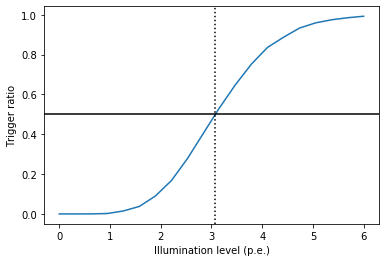

In [86]:
plt.plot(illumination_levels, ratio)
plt.axhline(0.5, color='black', ls='-')
plt.axvline(trigger_efficiency, color='black', ls=':')
plt.xlabel("Illumination level (p.e.)")
_ = plt.ylabel("Trigger ratio")

# Next Steps
- Explore the trigger efficiency as a function of Cherenkov shower image size. This requires creating a production chain of "realistic" images.
- Explore the backplane trigger efficiency and combinatorics